In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc

# Getting started with the `anndata` package

Suppose a colleague of yours did some single cell data analysis in Python and Scanpy, saving the results in an `AnnData` object and sending it to you in a `*.h5ad` file. This tutorial will walk you through that file and help you explore its structure and content --- even if you are new to anndata, Scanpy or Python.

In this tutorial, we will refer to anndata as the package, and to its data structures as `AnnData` objects, respectively.

## Exploring the `AnnData` object

We will use a preprocessed PBMC data set for our example. It is hosted on figshare and will be downloaded using the `pooch` package. The following line downloads the file `scverse-getting-started-anndata-pbmc3k_processed.h5ad` into `./data` (ca. 100MB).

In [2]:
datapath = pooch.retrieve(
    path=pooch.os_cache("scverse_tutorials"),
    url="https://exampledata.scverse.org/tutorials/scverse-getting-started-anndata-pbmc3k_processed.h5ad",
    known_hash="md5:b80deb0997f96b45d06f19c694e46243",
)

Now we can open it: Given a path to a `*.h5ad` file, `read_h5ad` will load the file into python and create our first `AnnData` object `adata`:

In [3]:
adata = anndata.read_h5ad(datapath)

(To load any `*.h5ad`file that already is on you machine, you would use `adata = anndata.read_h5ad('path/to/file.h5ad')`)

Let's have a first look at the `AnnData` object:

In [4]:
adata

AnnData object with n_obs × n_vars = 2638 × 11505
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types'
    var: 'gene_names', 'n_cells', 'gene_ids'
    uns: 'louvain', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw'
    obsp: 'distances_all'

This output tells us some general things about the data: its shape (2638 cells, 13714 genes) and which metadata fields and subfields it has. We will go through those one-by-one - let's start with the most important one:

### The *active* data matrix in `adata.X`

![Active data matrix X](img/X.png "Active data matrix X")

The `adata.X` slot holds the data matrix that we are actively using for analysis (e.g. for plotting gene expression values). That also means that most functions will use this data as input by default, unless explicitly told otherwise.

In this example, `adata.X` holds the matrix of normalized and log(1+x)-transformed mRNA counts. Its **rows are cells** (or observations), and its  **columns are genes** (or variables).

In [5]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2076576 stored elements and shape (2638, 11505)>

We see that the data matrix is stored in the [scipy sparse matrix format](https://docs.scipy.org/doc/scipy/reference/sparse.html) for compression. In brief, that means that we only store the non-zero expression values and their coordinates/indices in the data matrix explicitly, knowing that all other values are zeros. This saves a lot of RAM and makes processing faster, but also changes how we can interact with this object compared to a "normal" dense array. For an overview of the functions that you can apply directly on sparse arrays, check the [scipy.sparse docs for the csr array](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_array.html#scipy.sparse.csr_array). 

Here are some examples to show how the sparse format works:

In [6]:
# look at the non-zero values in the data
print(adata.X.data)
# look at their indices / positions in the data matrix
print(adata.X.indices)
# compute the fraction of non-zero entries
print(adata.X.nnz / np.prod(adata.X.shape))

[0.6496621 0.6496621 1.0402015 ... 0.7506172 0.7506172 1.4713064]
[   19    52    58 ... 11498 11501 11504]
0.068420527186156


### Alternative versions of the active data in `layers`

![Additional data layers with the same shape as X](img/layers.png "Additional data layers with the same shape as X")

The data representation that we want to use mostly for plotting and processing lives in `adata.X`, e.g. the normalized counts. In addition to that, we often want to keep additional versions of our data around, e.g. the raw counts. These versions must have the exact same shape as `adata.X` and can be found in `layers`. Technically, `layers` is a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) and stores each layer under a separate key.

In [7]:
adata.layers

Layers with keys: raw

Our data only has a single additional layer, the raw counts, accessible via the layer key `'raw'`:

In [8]:
adata.layers["raw"]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2076576 stored elements and shape (2638, 11505)>

Its also a sparse matrix with the same shape as the active data in `adata.X`, but with integer values:

In [9]:
adata.layers["raw"].data

array([1, 1, 2, ..., 1, 1, 3], shape=(2076576,))

Now let's add a new layer, for example "counts per million"-normalized counts. We can compute it from the `raw` layer and store it in `layers` with a new name:

In [10]:
# copy raw counts to new layer
adata.layers["counts_per_million"] = adata.layers["raw"].copy()
# normalize the new layer to counts-per-million
sc.pp.normalize_total(adata, target_sum=10**6, layer="counts_per_million")
print(adata.layers)

Layers with keys: raw, counts_per_million


Also note that we had to explicitly tell the normalization function from Scanpy to use the new `counts_per_million` layer as input and output! Many functions in the scverse ecosystem support this through using the `layer` argument - for example the following plotting function from `scanpy`:

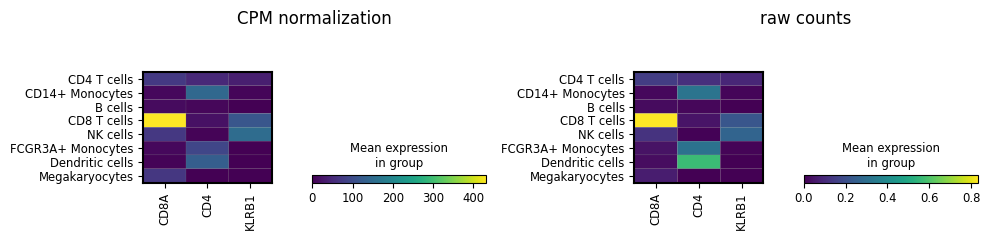

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
genes_of_interest = ["CD8A", "CD4", "KLRB1"]
sc.pl.matrixplot(
    adata,
    groupby="louvain_cell_types",
    var_names=genes_of_interest,
    layer="counts_per_million",  ## set which layer to plot
    ax=ax1,
    show=False,
)
ax1.set_title("CPM normalization")

sc.pl.matrixplot(
    adata,
    groupby="louvain_cell_types",
    var_names=genes_of_interest,
    layer="raw",  ## set which layer to plot
    ax=ax2,
    show=False,
)
ax2.set_title("raw counts")
plt.tight_layout()

### Simple annotations for cells and genes in `obs` and `var`

We usually want to store annotations for each cell and gene in `adata.X`. For cells, this can be the cluster assignments, batch IDs or a quality metric; for genes, it might be the gene name, ensembl ID or some measure of variance. 

In `AnnData` objects, this information lives in `adata.obs` for cell annotations - each of its rows correspond to a row / cell in `adata.X`. Similarly, `var` holds the gene annotations.

![Simple annotations for cells and genes](img/obsvar.png "Simple annotations for cells and genes in `obs` and `var`")

In [12]:
adata.obs

,n_genes,percent_mito,n_counts,louvain_cell_types
cell_barcode,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells


This table is a [Pandas Data Frame](https://pandas.pydata.org/). We can see from its columns that we currently have four cell annotations:
- the number of genes per cell
- fraction of counts from mitochondrial genes in each cell (a quality metric)
- total counts per cell
- cell type assignment of a louvain clustering

All of these annotations are one-dimensional - they contain a single number or string per cell. Also, each cell is uniquely identified by the index of the table - in this case, the cell barcoding sequence (more about indexing in the next section).

To get a list of all cell annotations in the `obs` columns, you can use

In [13]:
adata.obs.keys()

Index(['n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types'], dtype='object')

To access a specific column of the `obs` data frame, we can simply use its column name:

In [14]:
adata.obs["louvain_cell_types"]

cell_barcode
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain_cell_types, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

Now, we can directly interact with these annotations, e.g. count the numbers of B cells in the data:

In [15]:
print(sum(adata.obs["louvain_cell_types"] == "B cells"))

342


To add a new cell annotations, we simply add a new column to the `obs` data frame.

For example, if we want to keep track of low-quality cells with a high mitochondrial gene count fraction, we can do the following to mark all cells above a certain threshold:

In [16]:
adata.obs["is_low_quality"] = adata.obs["percent_mito"] > 0.03
adata.obs  # to inspect the updated table

,n_genes,percent_mito,n_counts,louvain_cell_types,is_low_quality
cell_barcode,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,True
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,True
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,False
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,False
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,False
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,False
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,False
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,False


The gene annotations in the `var` data frame work in the same way: Here, each row is a gene and in this example, the gene name is used as index. Additionally, the ensembl gene ID is available for each gene.

In [17]:
adata.var

,gene_names,n_cells,gene_ids
gene_names,,,
LINC00115,LINC00115,18,ENSG00000225880
NOC2L,NOC2L,258,ENSG00000188976
KLHL17,KLHL17,9,ENSG00000187961
PLEKHN1,PLEKHN1,7,ENSG00000187583
HES4,HES4,145,ENSG00000188290
...,...,...,...
MT-ND4L,MT-ND4L,398,ENSG00000212907
MT-ND4,MT-ND4,2588,ENSG00000198886
MT-ND5,MT-ND5,1399,ENSG00000198786


If you want to learn how to interact with the `obs` and `var` data frames in more advanced ways, you can have a look at these [Pandas tutorials](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html).

### Index cells and genes with `obs_names` and `var_names`

One important aspect of `AnnData` objects is the shared indexing. Consider the case of cell annotations - no matter if we look at a cells raw counts, its cluster assignments or its k-nearest neighbors in the PCA space: we always want to be able to refer to the same cell with the same "name". That is why all cell annotations share the same index, the `obs_names`. Similarly, we have `var_names` indexing our genes and their annotations. These annotations should be unique and many functions in the scverse ecosystem will raise warnings if this is not the case.

![Shared indexing for cells and genes](img/names.png "Shared indexing for cells and genes")

For the cells in our example data, the cell barcode from sequencing is used as index.

In [18]:
adata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name='cell_barcode', length=2638)

Genes are indexed by gene name in this example:

In [19]:
adata.var_names

Index(['LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4', 'ISG15', 'AGRN',
       'C1orf159', 'TNFRSF18', 'TNFRSF4',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', name='gene_names', length=11505)

If needed, we can change the way cells or genes are indexed by using a different index array for `obs_names` or `var_names`.  For that, we just need to set them to a new array of indices! For example, we can use the gene IDs instead of the gene name to index the genes:

In [20]:
adata.var_names = adata.var["gene_ids"]

As `adata.var_names` directly mirrors the index of `adata.var`, the index changes as expected:

In [21]:
adata.var

,gene_names,n_cells,gene_ids
gene_ids,,,
ENSG00000225880,LINC00115,18,ENSG00000225880
ENSG00000188976,NOC2L,258,ENSG00000188976
ENSG00000187961,KLHL17,9,ENSG00000187961
ENSG00000187583,PLEKHN1,7,ENSG00000187583
ENSG00000188290,HES4,145,ENSG00000188290
...,...,...,...
ENSG00000212907,MT-ND4L,398,ENSG00000212907
ENSG00000198886,MT-ND4,2588,ENSG00000198886
ENSG00000198786,MT-ND5,1399,ENSG00000198786


`AnnData` also automatically checks if the new index has the correct length - setting `var_names` with too few or too many indices will throw an error.

For now, let's go back to the gene name index, as it is more interpretable:

In [22]:
adata.var_names = adata.var["gene_names"]
adata.var

,gene_names,n_cells,gene_ids
gene_names,,,
LINC00115,LINC00115,18,ENSG00000225880
NOC2L,NOC2L,258,ENSG00000188976
KLHL17,KLHL17,9,ENSG00000187961
PLEKHN1,PLEKHN1,7,ENSG00000187583
HES4,HES4,145,ENSG00000188290
...,...,...,...
MT-ND4L,MT-ND4L,398,ENSG00000212907
MT-ND4,MT-ND4,2588,ENSG00000198886
MT-ND5,MT-ND5,1399,ENSG00000198786


### Subsetting `AnnData` objects

`AnnData` objects allow consistent subsetting of genes, cells or both.
There are several options to subset:
 - by name index (=`var_names` and/or `obs_names`) - in our example that would be lists of gene names `['LYZ','TUBB1','MALAT1']` or cell barcodes `[AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1']`
 - by numerical index - e.g. `:10` or `0:10` for the first 10 gene/cell, `5:10` for the sixth to the tenth, or `[0,2,4]` for the first, third and fifth
 - by boolean index - e.g. our flag for low-quality cells `adata.obs['is_low_quality']` or an index to all cells in the B cell cluster as in  `adata.obs['louvain']=='B cells'`
 
All of these index operations can be combined, and will automatically subset the active data in `adata.X`, all `layers`, and all annotation fields to the selected subset. For example, if we want to get the first five cells in the data for three specific genes we are interested in, `obs` and `var` will be subsetted.

In [23]:
adata_small = adata[:5, ["LYZ", "FOS", "MALAT1"]]
adata_small.shape

(5, 3)

In [24]:
# active data (log-normalized counts) after subsetting
adata_small.X.toarray()  # we use .toarray() just for display reasons here:
# it turns the sparse data in X into a dense array that can be nicely printed

array([[0.6496621 , 2.4036813 , 3.8249342 ],
       [0.8553989 , 0.64266497, 4.174533  ],
       [0.878057  , 2.8014445 , 4.7918878 ],
       [3.0494576 , 1.6464083 , 2.3237872 ],
       [0.        , 0.        , 3.923651  ]], dtype=float32)

In [25]:
# raw data layer after subsetting
adata_small.layers["raw"].toarray()

array([[  1,  11,  49],
       [  3,   2, 142],
       [  2,  22, 170],
       [ 24,   5,  11],
       [  0,   0,  22]])

In [26]:
# cell annotations after subsetting
adata_small.obs

,n_genes,percent_mito,n_counts,louvain_cell_types,is_low_quality
cell_barcode,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,True
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,True
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,False
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,False
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,False


In [27]:
# gene annotations after subsetting
adata_small.var

,gene_names,n_cells,gene_ids
gene_names,,,
LYZ,LYZ,1631,ENSG00000090382
FOS,FOS,2473,ENSG00000170345
MALAT1,MALAT1,2699,ENSG00000251562


Lets also try some boolean indexing, where we keep the gene axis unchanged (using `:`), and keeping only the high quality cells (by inverting `adata.obs['is_low_quality']` with the "NOT" operator `~`)

In [28]:
adata_high_quality = adata[~adata.obs["is_low_quality"], :]

In [29]:
# obs data frame after subsettings shows that the low-quality cells are gone
adata_high_quality.obs

,n_genes,percent_mito,n_counts,louvain_cell_types,is_low_quality
cell_barcode,,,,,
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,False
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,False
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,False
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,False
AAACGCTGTAGCCA-1,533,0.011765,1275.0,CD4 T cells,False
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,False
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,False
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,False


<div class="alert alert-info">
    
**Note:**

Technically, subsetting `AnnData` objects returns a _view_ of the `AnnData` you are subsetting from instead of making a copy. That avoids having the same data in memory twice. We describe the details of how views work in a separate section below.
</div>

### Multidimensional annotations for cells and genes in `obsm` and `varm`

In [30]:
adata.uns.keys()

dict_keys(['louvain', 'louvain_colors', 'pca'])

Sometimes, the simple, one-dimensional annotations in `obs` and `var` are not enough to store the results of our analysis. 

For example, if we embed our data with t-SNE or UMAP, we usually obtain a two-dimensional vector of embedding coordinates for each cell. For a PCA with, say, 50 components, we would even get a 50-dimensional vector per cell. To store these multidimensional representations of the cells, `AnnData` objects provide the `obsm` object. 

![Multidimensional information for cells and genes in `obsm` and `varm`](img/obsmvarm.png "Multidimensional information for cells and genes in `obsm` and `varm`")

For multidimensional information about genes, we have `varm`, which works similarly and could e.g. hold the PCA loadings for each gene.

Now, let's have a look at our example `adata.obsm`:

In [31]:
adata.obsm

AxisArrays with keys: X_pca, X_tsne, X_umap

In our example, it contains representation of our cells after PCA, t-SNE and UMAP. Technically, these three representations are stored in a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) with separate keys.

We can look at the data shape for each of them:

In [32]:
for key in adata.obsm:
    print(key, adata.obsm[key].shape, sep="\t")

X_pca	(2638, 50)
X_tsne	(2638, 2)
X_umap	(2638, 2)


The numbers of observations always has to be the same as in `adata.X`, but the number of dimensions can vary.

Also, let's make a simple plot of the the first two PCs from PCA and the UMAP / t-SNE embeddings, and highlight the B cells:

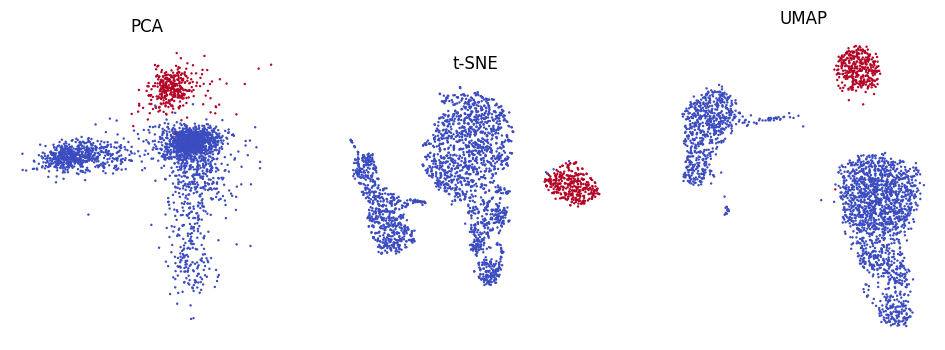

In [33]:
plt.figure(figsize=(12, 4))

# PCA
plt.subplot(1, 3, 1)
plt.scatter(
    x=adata.obsm["X_pca"][:, 0],  # PCA dim 1
    y=adata.obsm["X_pca"][:, 1],  # PCA dim 2
    c=adata.obs["louvain_cell_types"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("PCA")
plt.axis("off")
plt.gca().set_aspect("equal")

# t-SNE
plt.subplot(1, 3, 2)
plt.scatter(
    x=adata.obsm["X_tsne"][:, 0],  # t-SNE dim 1
    y=adata.obsm["X_tsne"][:, 1],  # t-SNE dim 2
    c=adata.obs["louvain_cell_types"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("t-SNE")
plt.axis("off")
plt.gca().set_aspect("equal")

# UMAP
plt.subplot(1, 3, 3)
plt.scatter(
    x=adata.obsm["X_umap"][:, 0],  # UMAP dim 1
    y=adata.obsm["X_umap"][:, 1],  # UMAP dim 2
    c=adata.obs["louvain_cell_types"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("UMAP")
plt.axis("off")
plt.gca().set_aspect("equal")

Note: There is a function in Scanpy to produce such [embedding scatter plots](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.embedding.html) automatically. We show the manual way here just to illustrate how the embeddings are stored in the `AnnData` object.

### Annotations for cell-cell and gene-gene pairs in `obsp` and `varp`

Many techniques in single cell data analysis consider pairs of cells or genes: For example, to construct a k-nearest neighbor graph of cells, we need to compute a distance matrix first. This matrix holds the distances between all pairs of cells. Similarly for genes, we might be interested of describing gene regulation networks with a matrix that quantifies for each gene-gene pair how strong they interact.

To store these matrices, `AnnData` has the `obsp` field for pairs of cells, and `varp` for pairs of genes.

![Multidimensional information for cells and genes in `obsm` and `varm`](img/obspvarp.png "Multidimensional information for cells and genes in `obsm` and `varm`")

Note that all matrices in `obsp` must have shape `(n_cells, n_cells)` and use `obs_names` as an index to both dimensions. Similarly, `varp` must be `(n_genes x n_genes)` and use `var_names` to index.

Our example data now holds the following cell-cell pair matrix:

In [34]:
adata.obsp

PairwiseArrays with keys: distances_all

`distances_all` is the the full distance matrix between all pairs of cells.

As before with `obsm` and `layers`, `obsp` is a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), so we can access the distance matrix by its key:

In [35]:
adata.obsp["distances_all"]

array([[ 0.        , 18.98223389, 15.39625646, ..., 17.44791227,
        19.66225537, 13.4530516 ],
       [18.98223389,  0.        , 21.37320952, ..., 17.39917931,
        16.59099551, 20.29010799],
       [15.39625646, 21.37320952,  0.        , ..., 17.48199881,
        19.54703132, 13.22466662],
       ...,
       [17.44791227, 17.39917931, 17.48199881, ...,  0.        ,
        14.53959947, 14.15720293],
       [19.66225537, 16.59099551, 19.54703132, ..., 14.53959947,
         0.        , 16.96518854],
       [13.4530516 , 20.29010799, 13.22466662, ..., 14.15720293,
        16.96518854,  0.        ]], shape=(2638, 2638))

Lets have a closer look at the full distance matrix and plot it!

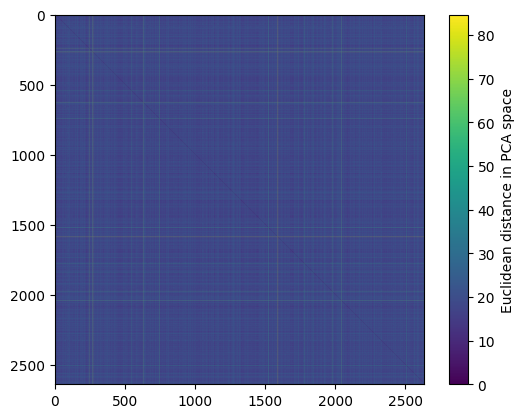

In [36]:
# plot distance matrix
plt.imshow(adata.obsp["distances_all"])
plt.colorbar(label="Euclidean distance in PCA space")
plt.show()

Here, we cannot see much structure. This is because the order of the cells is random! Therefore, let's re-order the cells such that they are sorted by cell type before plotting:

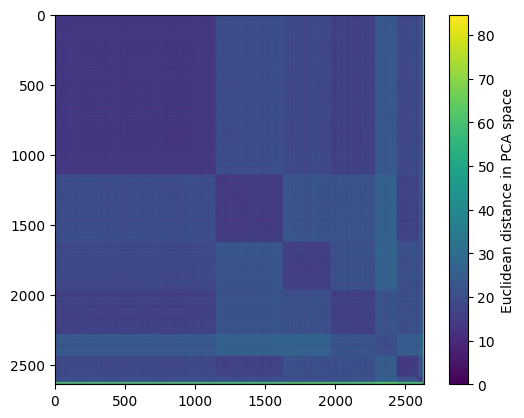

In [37]:
# generate numerical index to sort cells by louvain cluster assignments
reorder_by_celltype = np.argsort(adata.obs["louvain_cell_types"])
# same distance matrix plot as before, but with `adata` reordered!
plt.imshow(adata[reorder_by_celltype, :].obsp["distances_all"])
plt.colorbar(label="Euclidean distance in PCA space")
plt.show()

Now, we can clearly see the block structure of the cell-cell distance matrix. 

In summary, the `obsp` and `varp` fields allow to hold any kind of cell-cell or gene-gene paired data.

### Unstructured annotations or general metadata in `uns`

Finally, there is only one subfield left! If we have metadata that does not fit any of the other fields or that describes the whole dataset and not specific cells or genes, we can store it as unstructured annotation in `adata.uns`:

![Multidimensional information for cells and genes in `obsm` and `varm`](img/anndata_schema_full.png "Multidimensional information for cells and genes in `obsm` and `varm`")

`adata.uns` is another Python dictionary, so we can access its contents via its keys:

In [38]:
adata.uns.keys()

dict_keys(['louvain', 'louvain_colors', 'pca'])

In our example, `uns` holds some processing parameters or intermediate results of the methods that were already run on the data. 

Let's look at the `pca` and `louvain` fields:

In [39]:
# louvain clustering parameters
print(adata.uns["louvain"])

{'params': {'random_state': array([0]), 'resolution': array([1])}}


In [40]:
# louvain clustering plotting colors
print(adata.uns["louvain_colors"])

['#1f77b4' '#ff7f0e' '#2ca02c' '#d62728' '#9467bd' '#8c564b' '#e377c2'
 '#bcbd22']


In [41]:
# PCA: variance explained
print(adata.uns["pca"])

{'variance': array([32.11044  , 18.718647 , 15.607319 , 13.235274 ,  4.8012376,
        3.977329 ,  3.5053132,  3.1576602,  3.028463 ,  2.9777625,
        2.8842385,  2.8583548,  2.849085 ,  2.8220255,  2.811057 ,
        2.781576 ,  2.7436602,  2.7404478,  2.736062 ,  2.6872916,
        2.671316 ,  2.6690092,  2.6442325,  2.6394093,  2.6157827,
        2.6102393,  2.575101 ,  2.5691617,  2.563295 ,  2.5489197,
        2.5080354,  2.4762378,  2.264355 ,  2.1844513,  2.1353922,
        2.096509 ,  2.0606086,  2.0105643,  1.9703175,  1.9465197,
        1.9220033,  1.8847997,  1.8349565,  1.8038161,  1.7930729,
        1.7611799,  1.7322571,  1.721284 ,  1.6937429,  1.6519767],
      dtype=float32), 'variance_ratio': array([0.02012818, 0.01173364, 0.00978333, 0.00829643, 0.00300962,
       0.00249316, 0.00219728, 0.00197936, 0.00189837, 0.00186659,
       0.00180796, 0.00179174, 0.00178593, 0.00176896, 0.00176209,
       0.00174361, 0.00171984, 0.00171783, 0.00171508, 0.00168451,
       0

In summary, the `adata.uns` field is helpful to store metadata that relates to the dataset as a whole (processing parameters, experimental details etc.).

### Views and copies of `AnnData` objects

As we mentioned in the section on subsetting, whenever you subset an `AnnData` objects, you will always get a view in return instead of making a copy. That avoids having the same data in memory twice. Sometimes you will want to have a copy instead of a view, i.e. to modify the subset independent of the parent `AnnData` object. We will get to that below - but first, let's demonstrate what a "view" is.

For that, we first look at a 5x5 subset of our active data matrix, by indexing `X` directly. We add `.toarray()` to turn the sparse `X` into a nice print-out:

In [42]:
adata.X[:5, 5:10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.64266497, 0.        ],
       [0.532456  , 0.        , 0.        , 0.        , 0.        ],
       [2.1446393 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

Now, if we index `adata` directly, we get a "view" - that means it does _not_ copy the data of our 5x5 subset and stores it somewhere. Instead, when we use it, it will use the data of the original `AnnData` object that is already in memory.

In [43]:
adata_view = adata[:5, 5:10]
adata_view

View of AnnData object with n_obs × n_vars = 5 × 5
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types', 'is_low_quality'
    var: 'gene_names', 'n_cells', 'gene_ids'
    uns: 'louvain', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw', 'counts_per_million'
    obsp: 'distances_all'

Of course, the data inside the `.X` of our `adata_view` is exactly our subset from above:

In [44]:
adata_view.X.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.64266497, 0.        ],
       [0.532456  , 0.        , 0.        , 0.        , 0.        ],
       [2.1446393 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

However, what if we change something in the parent `AnnData` object? Lets add a fake value in the first row of the original `adata.X` and then check what happens see what happens in the `X` of the view:

In [45]:
adata.X[0, 7] = 99
adata_view.X.toarray()

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


array([[ 0.        ,  0.        , 99.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.64266497,  0.        ],
       [ 0.532456  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.1446393 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

The change propagated as expected! Because the view just mirrors the parent `AnnData` object, we can see the fake value inserted in the parent `X` also in the view.

<div class="alert alert-info">

**Note**
    
Propagating changes from a parent `AnnData` object to its view(s) currently works for all numpy-derived fields (`X`, `layers`, `obsm`, `varm`, `obsp` and `varp`) but _not_ for the pandas-derived `obs` and `var` dataframes! See this [github issue](https://github.com/scverse/anndata/issues/887) for status updates.
    
</div>

#### Turn a view into a copy

As mentioned above, sometimes you might want a copy of the parent `AnnData` instead of just a view. You can get an actual `AnnData` object from a view in two ways:
- call `.copy()` on the view - a copy is returned
- modify any of elements of the view - the view object will be turned into copy

Lets try this - we start with the `adata_view` that we created above:

In [46]:
adata_view  # still a view

View of AnnData object with n_obs × n_vars = 5 × 5
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types', 'is_low_quality'
    var: 'gene_names', 'n_cells', 'gene_ids'
    uns: 'louvain', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw', 'counts_per_million'
    obsp: 'distances_all'

In [47]:
adata_view_copy = adata_view.copy()
adata_view_copy  # an actual AnnData object!

AnnData object with n_obs × n_vars = 5 × 5
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types', 'is_low_quality'
    var: 'gene_names', 'n_cells', 'gene_ids'
    uns: 'louvain', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw', 'counts_per_million'
    obsp: 'distances_all'

In [48]:
adata_view.obs["new_column"] = "Test"  # add a new column to the `obs` dataframe
adata_view  # Not a view anymore!

/tmp/ipykernel_2851/3524272241.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_view.obs["new_column"] = "Test"  # add a new column to the `obs` dataframe


AnnData object with n_obs × n_vars = 5 × 5
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types', 'is_low_quality', 'new_column'
    var: 'gene_names', 'n_cells', 'gene_ids'
    uns: 'louvain', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw', 'counts_per_million'
    obsp: 'distances_all'

Note that when we modified the `adata_view`, this not only turned `adata_view` into a propper `AnnData` object by making a copy internally - it also triggered the `ImplicitModificationWarning` to let you know what happened.

Now, both `adata_view_copy` and `adata_view` store actual data and are separated from their parent `AnnData` object `adata`. We can demonstrate that by adding another fake value to `adata.X` as before:

In [49]:
adata.X[0, 8] = 98
adata.X[:5, 5:10].toarray()  # the parent of course has the change

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


array([[ 0.        ,  0.        , 99.        , 98.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.64266497,  0.        ],
       [ 0.532456  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.1446393 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [50]:
adata_view.X.toarray()  # the former view (that now is a actual AnnData object) does not have it

array([[ 0.        ,  0.        , 99.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.64266497,  0.        ],
       [ 0.532456  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.1446393 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [51]:
adata_view_copy.X.toarray()  # the copy of the view (also an actual AnnData object) does not have it either

array([[ 0.        ,  0.        , 99.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.64266497,  0.        ],
       [ 0.532456  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.1446393 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In summary, views can help to quickly create a subset of an existing `AnnData` object without using additional memory. However, if you modify them, they will turn into an actual `AnnData` object and contain a separate copy of the data you subsetted.

## Where can I get help, and what tutorial should I try next?

This is the end of the this introductory tutorial. You can find more details on `anndata` functionality on the [documentation page](https://anndata.readthedocs.io/en/latest/). On the `anndata` [GitHub] you can read about and report new technical issues. On the [scverse Discord](https://discourse.scverse.org/) you can ask questions to the scverse community and get help from our developers.


### `MuData`: `AnnData`, but for multimodal datasets

`mudata` is the extension of `anndata` to multimodal datasets, i.e. whenever you have high-dimensional observations from more than one modality (e.g. combined scRNA and scATAC data) and want to manage annotations of cells/genes/... in a consistent and convenient way. It builds intuitively on `anndata` by treating the data from each modality as a separate `AnnData` object, but combining them to a joint, multimodal way in the `MuData` object. Try the [introductory tutorial](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html) to get started, and see the page on [multimodal data containers](https://muon.readthedocs.io/en/latest/io/mudata.html) to get a first overview of the `MuData` object and its contents.

### Advanced tutorials

For some advanced topics, we have dedicated tutorials that you can try next. They can be found on the [scverse tutorial page](https://scverse.org/learn/). Here are a few recommendations:

- Coming to Python&scverse from R? Try our [interoperability tutorial](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/scverse_data_interoperability.html), where we show how `AnnData` objects can be interfaced with single cell data structures from other languages (e.g. `Seurat`. `SingleCellExperiment`, ...)
- Work with large datasets and don't want to fully load them into memory? Check out our `anndata`s [backed mode tutorial](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/scverse_data_backed.html)
- Want to combine datasets? We a [tutorial on how axes and concatenation work](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/tutorial_axes_anndata_mudata.html) for both `AnnData` and `MuData` objects. 
<!-- - Want to start with your scRNA analysis? Here is our [example scRNA processing workflow_LINK_MISSING](LINK) in `scanpy`. -->